In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from utils import get_new_fig_and_ax, save_fig


mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
mpl.rcParams['legend.framealpha'] = 0.0
fig_id = 0

### Details for implementing the exact algorithm for Gaussian measures.

To implement the exact algorithm, we need to make the following considerations:

- First, given Sinkhorn iterates $\psi^{j}$, assumed to be quadratic functions, what is the corresponding optimal paired potential $\phi^{j} = \phi_{\psi^{j}}$?
- Second, once the potentials $\phi^{j}$ and the weights $w_{j}$ are chosen, how to compute the probability measure $\mu(dx) \propto \exp(-V(x)/\tau)dx$, where $V(x) = \sum_{j} w_{j}\phi^{j}(x)$?
- Third, once $\mu$ is updated, how to update the Sinkhorn iterates $\psi$?

It turns out that starting with $\psi^{j} = 0$ for $j=1,\dots,k$, the Sinkhorn iterates $\psi,\phi$ will always remain quadratic functions, and $\mu$ will always be a Gaussian measure, provided that all the marginals $\nu^{j}$ are also Gaussian. We provide a sketch of the details below.

#### Computation of the optimal Sinkhorn potential for a given $\psi$.

Let $\psi(y) = \frac{1}{2}y^{\top}A y - b^{\top}y$ for some symmetric invertible matrix $A \in \mathbb{R}^{d \times d}$ and a vector $b \in \mathbb{R}^{d}$.

Let $\phi(x) = \phi_{\psi}(x) = -\lambda \log \int_{\mathbb{R}^{d}} \exp\left(\frac{\psi(y) - \frac{1}{2}\|x - y\|_{2}^{2}}{\lambda}\right)\nu(dy)$.

When $\nu$ is Gaussian measure with mean $m \in \mathbb{R}^{d}$ and invertible covariance matrix $\Sigma$, then a direct computation based on completing the square and computing a Gaussian integral yields the expression (the notation $\propto$ drops constant factors independent of $x$; $t = \lambda^{-1}$ for a simpler notation):
\begin{align*}
    &\mathbf{E}_{Y \sim N(m, \Sigma)}\left[
        \exp\left(t[\psi(y) - \frac{1}{2}\|x-y\|_{2}^{2}\right)
    \right]
    \\
    &\propto
    \exp\left(-t\|x\|^{2}/2\right)
    \int_{\mathbb{R}^{d}}
    \exp\left(
        -\frac{1}{2}(y-m)^{\top}\Sigma^{-1}(y-m)
        +\frac{1}{2}y^{\top}[-tI_{d} + tA]y
        + y^{\top}[tx - tb]
    \right)
    dy
    \\
    &\propto
    \exp\left(-t\|x\|^{2}/2\right)
    \int_{\mathbb{R}^{d}}
    \exp\left(
        -\frac{1}{2}y^{\top}\Sigma^{-1}y
        +\frac{1}{2}y^{\top}[-tI_{d} + tA]y
        + y^{\top}[tx - tb + \Sigma^{-1}m]
    \right)
    dy
    \\    
    &\propto
    \exp\left(-t\|x\|^{2}/2\right)
    \exp\left(\frac{1}{2}(tx - tb + \Sigma^{-1}m)^{\top}
    \left[\Sigma^{-1} + tI_{d} - tA\right]^{-1}
    (tx - tb + \Sigma^{-1}m)\right).
\end{align*}
Thus, we have
$$
  \phi(x) = \mathrm{const} + \frac{1}{2}x^{\top}Cx - d^{\top}x
$$
where
  $$
  C = I_{d} - \lambda^{-1}\left[\Sigma^{-1} + \lambda^{-1} I_{d} - \lambda^{-1} A\right]^{-1}
  $$
  and
  $$
    d =
    \left[\Sigma^{-1} + \lambda^{-1} I_{d} - \lambda^{-1} A\right]^{-1}
    (\Sigma^{-1}m - \lambda^{-1}b).
  $$
These computations are implemented in the following function.

In [2]:
def compute_C_d(A, b, Sigma, m, lamda):
    """ Input: a matrix A and a vector b such that \psi(y) = 1/2 y^t A y - y^t b;
               a matrix Sigma and a vector m such that \nu is N(m, Sigma).
        Output: a matrix C and a vector d such that \phi(x) = const + 1/2 x^t C x - d^{t} x.
    """
    # Check that dimensions match.
    d = A.shape[0]
    assert A.shape[0] == A.shape[1] and len(A.shape) == 2
    assert Sigma.shape == A.shape
    b = b.reshape(d,1)
    m = m.reshape(d,1)
    
    Id = np.identity(d)
    Sigma_inv = np.linalg.inv(Sigma)
    U = Sigma_inv + 1.0/lamda * Id - 1.0/lamda * A
    U = np.linalg.inv(U)
    
    C =  Id - 1.0/lamda * U
    d = U @ (Sigma_inv @ m - 1.0/lamda * b)
   
    return C, d

#### Updating the barycenter.

When $V(x) = \frac{1}{2}x^{\top}C x - d^{\top}x + \mathrm{const}$, then the probability measure $\mu(dx) \propto \exp\left(-\frac{V(x)}{\tau}\right)dx$ is Gaussian with mean $C^{-1}d$ and covariance Matrix $\tau C^{-1}$.
Indeed, we have
$$
  \exp\left(-\frac{V(x)}{\tau}\right)dx
  \propto
  \exp\left(-\frac{1}{2}x^{\top}(\tau^{-1}C)x + \tau^{-1}d^{\top}(I_{d})x \right)dx
  \propto
   \exp\left(-\frac{1}{2}(x-C^{-1}d)^{\top}(\tau^{-1}C)(x - C^{-1}d)\right)dx,
$$
from which the above observation follows.

Hence, we can implement the running barycenter update as done in the following cell.

In [3]:
def update_barycenter(Cs, ds, ws, tau):
    """ Input: Cs is a list of k matrices [C^1, ..., C^k],
               ds is a list of k vectors [d^1, ..., d^k],
               ws is a list of k weights specifying barycenter weights,
               tau is the outer-regularization strength.
               
               For the j-th marginal, the matrix C = C^j abd d = d^j are such that
               phi_psi(x) = 1/2 x^t C x - d^t x + const.
               
        Output (m, Sigma) specifying the Gaussian parameters of the updated running barycenter.
    """
    assert len(Cs) == len(ds)
    assert len(Cs) == len(ws)
    k = len(Cs)
    C = np.zeros_like(Cs[0])
    d = np.zeros_like(ds[0])
    for j in range(k):
        C += Cs[j] * ws[j]
        d += ds[j] * ws[j]
        
    C_inv = np.linalg.inv(C)
    return (C_inv @ d).reshape(-1,1), tau * C_inv

#### Updating the Sinkhorn iterates $\psi^{j}$.

The Sinkhorn iterates (skipping index $j$ for convenience) are updated via the rule
$$
  \psi_{t+1}(y) = \psi_{t}(y) - \eta \lambda \log \frac{d\nu_{t}}{d\nu}(y),
$$
where $\eta \in (0,1]$ is a damping factor.

We have
$$
  -\lambda \log \frac{d\nu_{t}}{d\nu}(y)
  =
  - \psi(y)
  - \lambda \log
  \int_{\mathbb{R}^{d}} \exp\left(\frac{\phi_{\psi}(x) - \frac{1}{2}\|x-y\|_{2}^{2}}{\lambda}\right)\mu_{t}(dx)
$$
Because $\mu_{t}$ is Gaussian and $\phi_{\psi}$ is quadratic, we can compute the above integral explicitly.

When $\phi(x) = \frac{1}{2}x^{\top}Cx + d^{\top}x + \mathrm{const}$
and $\mu_{t}$ is Gaussian with mean $m_{t}$ and covariance $\Sigma_{t}$, then 
$$
  -\lambda \log \frac{d\nu_{t}}{d\nu}(y)
  = -\psi(y) + \frac{1}{2}y^{t}F y - g^{t} y + \mathrm{const},
$$
where computing $(g,F)$ from $(c, D)$ and $\mu_{t}$ can be used via the previous formula used for computation of $(c, D)$ from $(b, A)$ and $\nu$.


### Implementation of the exact scheme for Gaussians

In [4]:
class ExactScheme(object):
    
    def __init__(self, Sigmas, ms, ws, lamda, tau):
        """
            Input:
                - The marginals are Gaussian with nu_{j} = N(ms[j], Sigmas[j]).
                - ws are the weights of the marginals.
                - lamda and tau are inner and outer regularization strenghts, respectively.
        """
        assert len(Sigmas) == len(ms) and len(Sigmas) == len(ws)
        self.k = len(Sigmas)
        self.d = Sigmas[0].shape[0]
        
        # Check that weights sum to one.
        assert abs(sum(ws) - 1.0) <= 1e-8
        
        self.Sigmas = Sigmas
        self.ms = ms
        self.ws = ws
        
        d = self.Sigmas[0].shape[0]
        for j in range(self.k):
            self.Sigmas[j].reshape(d,d)
            self.ms[j].reshape(d, 1)
        
        self.lamda = lamda
        self.tau = tau
        
        # Initialize the psis, which is the state of the iterates.
        # Each psi is represented as a tuple (A, b), representing
        # psi(y) = 1/2 y^t A y - b^t y + const, for an arbitrary constant.
        self.psis = []
        for j in range(self.k):
            A = np.zeros((d, d))
            b = np.zeros((d,1))
            self.psis.append((A,b))
            
        # We now need to compute phis.
        self.phis = [0] * self.k
        self.update_phis()
        
        # Update the running barycenter, stored via the mean and covariance
        # matrix of a Gaussian distribution.
        self.mu = None, None
        self.update_mu()
        
        
    def update_phis(self):
        """ Given the current state of psis, computes all phis and updates self.phis. """
        for j in range(self.k):
            A, b = self.psis[j]
            C, d = compute_C_d(A, b, self.Sigmas[j], self.ms[j], self.lamda)
            self.phis[j] = (C, d)
    
    def update_mu(self):
        """ Given the curent state of psis, returns (m, Sigma) sucht that the current
        iterate is mu_t = N(m, Sigma). """
        Cs = []
        ds = []
        for j in range(self.k):
            C, d = self.phis[j]
            Cs.append(C)
            ds.append(d)
        m, Sigma = update_barycenter(Cs, ds, self.ws, self.tau)
        self.mu = m, Sigma
        
    def iterate(self, eta):
        """ Performs one iteration of the algorithm.
        The vairable eta in (0,1] is the damping factor. """
        for j in range(self.k):
            A, b = self.psis[j]
            C, d = self.phis[j]
            m, Sigma = self.mu
            # Compute undamped update.
            F, g = compute_C_d(C, d, Sigma, m, self.lamda)
            # Update A,b.
            self.psis[j] = (A*(1.0-eta) + eta*F, b*(1.0-eta) + eta*g)
            
        self.update_phis()
        self.update_mu()
        
    def reset_psis(self):
        for j in range(self.k):
            A, b = self.psis[j]
            self.psis[j] = (A * 0.0, b * 0.0)
        self.update_phis()
        self.update_mu()

#### Closed form expressions for Isotropic Gaussians

Proposition 3.4 in https://arxiv.org/pdf/2303.11844.pdf gives closed form expressions for isotropic Gaussian barycenters. We implement them below.

In [5]:
class IsotropicGaussianSetup(object):
    
    @staticmethod
    def compute_optimal_barycenter(means, ws, var, lamda, tau):
        # Means give the means of the marginals; ws are the weights.
        # Parameter var is the variance of the isotropic marginals.
        # The true measure is isotropic Gaussian.
        # We compute its parameters.
        assert len(means) == len(ws)
        ws = np.array(ws).flatten()
        
        # Compute the true mean.
        m_star = np.zeros_like(means[0])
        for j in range(len(ws)):
            m_star += ws[j] * means[j]
            
        # Compute the true variance var_star.
        var_star =  var + np.sqrt((var-lamda)**2 + 4*var*tau)
        var_star = var_star**2 - lamda**2
        var_star /= 4.0 * var
        
        return m_star, var_star
    
    @staticmethod
    def compute_KL(m, Sigma, m_star, var_star):
        # Computes KL(nu*, nu) between the true barycenter nu* and nu = N(m, Sigma),
        # where nu* = N(m_star, var_star * Id).
        delta_m = m.reshape(-1,1) - m_star.reshape(-1,1)
        Sigma_inv = np.linalg.inv(Sigma)
        d = Sigma.shape[0]
        KL = delta_m.transpose() @ Sigma_inv @ delta_m
        Sigma_star = np.identity(d) * var_star
        KL = var_star * np.trace(Sigma_inv) - d - np.log(np.linalg.det(Sigma_star)/np.linalg.det(Sigma))
        return KL*0.5
    
    @staticmethod
    def run_simulation(algorithm, n_iter, eta):
        # Reset the state by initializing psis to 0.
        algorithm.reset_psis()
        d = algorithm.d
        
        # Check that the marginals are isotropic Gaussinans with the same variance.
        var = algorithm.Sigmas[0][0,0]
        test_Sigma = np.identity(d)*var # All covariances should be the same.
        for j in range(algorithm.k):
            assert np.allclose(algorithm.Sigmas[j], test_Sigma)
            
        # Compute the true barycenter (stored in self.m_star, self.var_star).
        m_star, var_star = IsotropicGaussianSetup.compute_optimal_barycenter(
            algorithm.ms, algorithm.ws, var, algorithm.lamda, algorithm.tau)
        Sigma_star = var_star * np.identity(d)

        # The below parameters will store the simulation output.
        Sigma_t = np.zeros((n_iter, d, d))
        m_t = np.zeros((n_iter, d))
        KL = np.zeros(n_iter) # KL(mu* || mu_t).
        delta_means = np.zeros(n_iter) # squared Euclidean norm.
        delta_covariances = np.zeros(n_iter) # squared Frobenius norm.
        
        for t in range(n_iter):
            m, Sigma = algorithm.mu
            
            Sigma_t[t,:,:] = Sigma
            m_t[t,:] = m.flatten()
            KL[t] = IsotropicGaussianSetup.compute_KL(m, Sigma, m_star, var_star)
            delta_means[t] = np.sum((m - m_star)**2)
            delta_covariances[t] = np.sum((Sigma_star - Sigma)**2)
            
            algorithm.iterate(eta)
            
        return {
            'Sigma_t' : Sigma_t,
            'm_t' : m_t,
            'KL' : KL,
            'delta_means' : delta_means,
            'delta_covariances' : delta_covariances
        }

### Simulations - Exact Algorithm

When the marginals are isotropic with the same variance, the number of marginals and the dimension plays no role - we are essentially trying to learn the variance of the true barycenter.

Hence, we may focus on the setup n=1, d=1, and with arbitrary mean (we take mean zero).

In [6]:
# Setup.
k = 1
ws = [1.0/k] * k
d = 1
Sigmas = [np.identity(d)*1.0] * k
ms = [np.zeros(d)] * k
lamda = 1e-3

#### Explosion of undamped iterates.

/tmp/ipykernel_53463/1365246289.py:33: RuntimeWarning: invalid value encountered in log
  KL = var_star * np.trace(Sigma_inv) - d - np.log(np.linalg.det(Sigma_star)/np.linalg.det(Sigma))
/tmp/ipykernel_53463/1538624680.py:13: RuntimeWarning: invalid value encountered in log
  ax.plot(np.log(output['KL']))


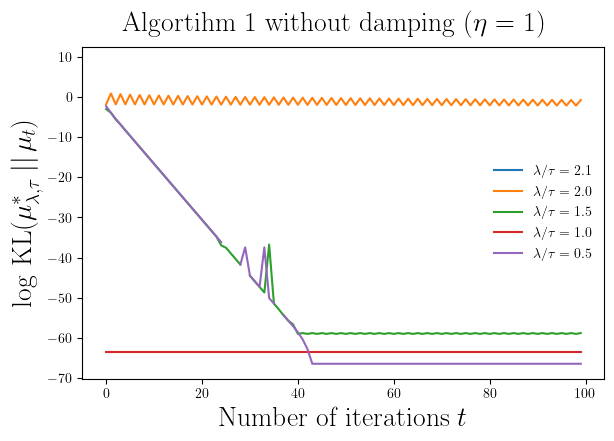

In [7]:
# We will now investigate the behavior of the undamped algorithm.

lamda_tau_ratios = [2.1, 2.0, 1.5, 1.0, 0.5]

fig_id += 1
fig, ax = get_new_fig_and_ax(fig_id, 6, 4)
legend = []

for ltr in lamda_tau_ratios:
    tau = lamda/ltr
    alg = ExactScheme(Sigmas, ms, ws, lamda, tau)
    output = IsotropicGaussianSetup.run_simulation(algorithm=alg, n_iter=100, eta=1.0)
    ax.plot(np.log(output['KL']))
    legend.append(r'$\lambda/\tau ='+str(ltr)+'$')
    
ax.set_xlabel(r"Number of iterations $t$", fontsize=20)
ax.set_ylabel(r"$\log\, \mathrm{KL}(\mu^{*}_{\lambda, \tau}\, ||\, \mu_{t})$", fontsize=20)
ax.legend(legend)
fig.suptitle(r"Algortihm 1 without damping ($\eta = 1$)", fontsize=20, y=1.03)
save_fig(fig, "./figures/exact_undamped_explosion.pdf")

#### The critical case $\tau \approx \lambda/2$

/tmp/ipykernel_53463/1365246289.py:33: RuntimeWarning: invalid value encountered in log
  KL = var_star * np.trace(Sigma_inv) - d - np.log(np.linalg.det(Sigma_star)/np.linalg.det(Sigma))
/tmp/ipykernel_53463/945058176.py:11: RuntimeWarning: invalid value encountered in log
  ax.plot(np.log(output['KL']))


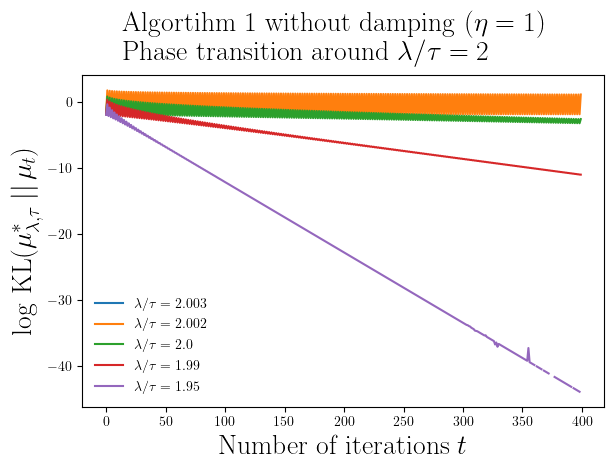

In [8]:
lamda_tau_ratios = [2.003, 2.002, 2.0, 1.99, 1.95]

fig_id += 1
fig, ax = get_new_fig_and_ax(fig_id, 6, 4)
legend = []

for ltr in lamda_tau_ratios:
    tau = lamda/ltr
    alg = ExactScheme(Sigmas, ms, ws, lamda, tau)
    output = IsotropicGaussianSetup.run_simulation(algorithm=alg, n_iter=400, eta=1.0)
    ax.plot(np.log(output['KL']))
    legend.append(r'$\lambda/\tau ='+str(ltr)+'$')
    
ax.set_xlabel(r"Number of iterations $t$", fontsize=20)
ax.set_ylabel(r"$\log\, \mathrm{KL}(\mu^{*}_{\lambda, \tau}\, ||\, \mu_{t})$", fontsize=20)
ax.legend(legend)
fig.suptitle(r"\noindent Algortihm 1 without damping ($\eta = 1$)\\"
             r"Phase transition around $\lambda/\tau = 2$",
             fontsize=20, y=1.1)
save_fig(fig, "./figures/phase_transition.pdf")

#### Damping helps

/tmp/ipykernel_53463/1898095336.py:11: RuntimeWarning: invalid value encountered in log
  ax.plot(np.log(output['KL']))


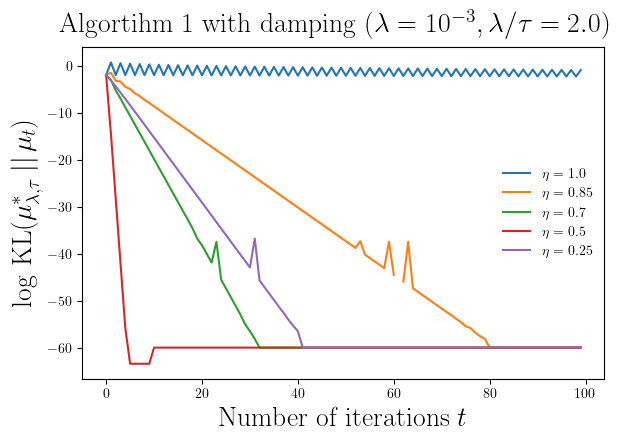

In [9]:
etas = [1.0, 0.85, 0.7, 0.5, 0.25]

fig_id += 1
fig, ax = get_new_fig_and_ax(fig_id, 6, 4)
legend = []

tau = lamda / 2.0
for eta in etas:
    alg = ExactScheme(Sigmas, ms, ws, lamda, tau)
    output = IsotropicGaussianSetup.run_simulation(algorithm=alg, n_iter=100, eta=eta)
    ax.plot(np.log(output['KL']))
    legend.append(r'$\eta ='+str(eta)+'$')
    
ax.set_xlabel(r"Number of iterations $t$", fontsize=20)
ax.set_ylabel(r"$\log\, \mathrm{KL}(\mu^{*}_{\lambda, \tau}\, ||\, \mu_{t})$", fontsize=20)
ax.legend(legend)
fig.suptitle(r"\noindent Algortihm 1 with damping ($\lambda = 10^{-3},\lambda/\tau = 2.0$)",
             fontsize=20, y=1.03)
save_fig(fig, "./figures/damping_helps.pdf")

### Simulations - Inexact Algorithm

In [10]:
class InexactScheme(ExactScheme):
    
    def __init__(self, Sigmas, ms, ws, lamda, tau, noise=1e-3):
        self.noise = noise
        super().__init__(Sigmas,ms,ws,lamda,tau)
        
    def iterate(self, eta):
        # Call the exacht scheme.
        super().iterate(eta)
        
        # Now inject some noise in phis.
        d = self.psis[0][0].shape[0]
        for j in range(self.k):           
            N = self.sample_noise_matrix()
            # Perturb A and b with noise.
            A, b = self.psis[j]
            self.psis[j] = (A - N, b)
            
        # Update phis and mu.
        self.update_phis()
        self.update_mu()
    
    def sample_noise_matrix(self):
        # Generate a random noise perturbation matrix.
        N = np.random.normal(0.,1., size=(d,d))
        N = N @ np.transpose(N) # Make it symmetrics psd.
        N /= np.trace(N)
        N *= self.noise # Make the noise small.     
        return N
    
    def reset_psis(self):
        for j in range(self.k):
            A, b = self.psis[j]
            N = self.sample_noise_matrix()
            self.psis[j] = (-N, b * 0.0)
            
        self.update_phis()
        self.update_mu()

#### Undamped Algorithm With Noise

In [11]:
# Setup.
np.random.seed(0)
k = 3
ws = [1.0/k] * k
d = 10
Sigmas = [np.identity(d)*1.0] * k
lamda = 1e-3
ms = []
for j in range(k):
    ms.append(np.random.normal(0,1,size=(d,))) # Draw means from i.i.d. N(0,1).

/tmp/ipykernel_53463/1365246289.py:33: RuntimeWarning: invalid value encountered in log
  KL = var_star * np.trace(Sigma_inv) - d - np.log(np.linalg.det(Sigma_star)/np.linalg.det(Sigma))
/tmp/ipykernel_53463/1358772546.py:12: RuntimeWarning: invalid value encountered in log
  ax[idx].plot(np.log(output['KL'])[1:])


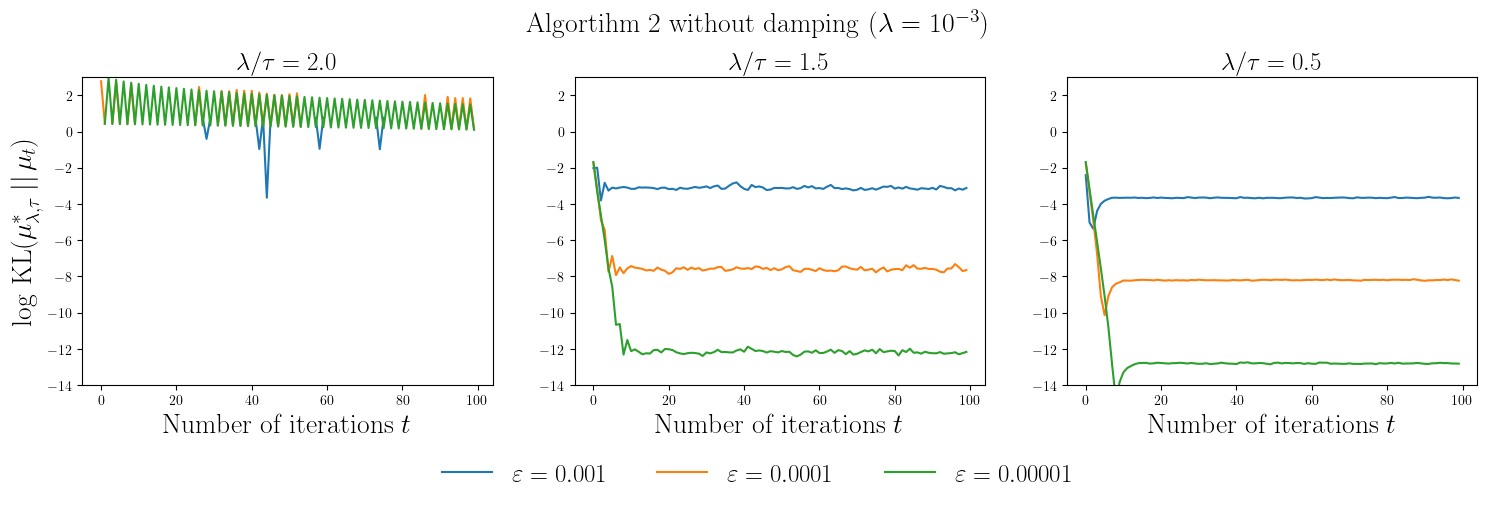

In [12]:
np.random.seed(0)

ratios = [2.0, 1.5, 0.5]
fig, ax = plt.subplots(1, len(ratios), figsize=(6*len(ratios),4))

for idx, ratio in enumerate(ratios):
    tau = lamda / ratio
    noise_levels = [10**(-3), 10**(-4),10**(-5)]
    for noise in noise_levels:
        alg = InexactScheme(Sigmas, ms, ws, lamda, tau, noise=noise)
        output = IsotropicGaussianSetup.run_simulation(algorithm=alg, n_iter=101, eta=1.0)
        ax[idx].plot(np.log(output['KL'])[1:])
        noise_str = np.format_float_positional(np.float16(np.pi))

    ax[idx].set_xlabel(r"Number of iterations $t$", fontsize=20)
    if idx == 0:
        ax[idx].set_ylabel(r"$\log\, \mathrm{KL}(\mu^{*}_{\lambda, \tau}\, ||\, \mu_{t})$", fontsize=20)
    ax[idx].set_title(r"$\lambda/\tau = "+str(ratio)+"$", fontsize=18)
    ax[idx].set_ylim((-14, 3))
    
labels = [r'$\varepsilon='+np.format_float_positional(np.float16(noise))+'$' for noise in noise_levels]
fig.legend(ax[0].get_lines(), labels, loc='upper center', ncol=len(labels), fontsize=18, bbox_to_anchor=(0.5, -0.03))
    
fig.suptitle(r"\noindent Algortihm 2 without damping ($\lambda = 10^{-3}$)",
             fontsize=20, y=1.05)
save_fig(fig, "./figures/inexact_algorithm_without_damping.pdf")

#### Damped Algorithm With Noise

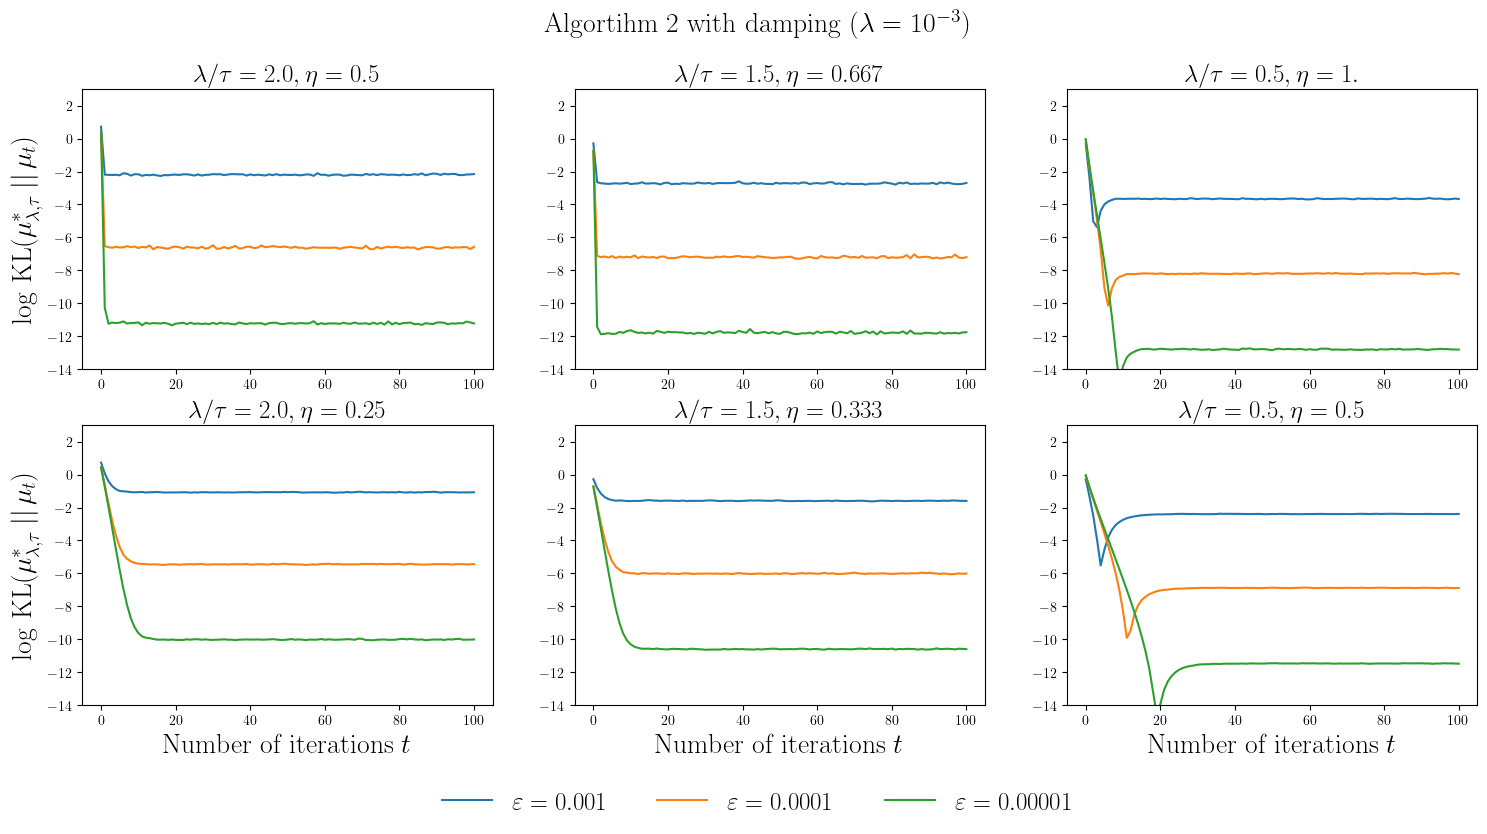

In [13]:
np.random.seed(0)

ratios = [2.0, 1.5, 0.5]
fig, ax = plt.subplots(2, len(ratios), figsize=(6*len(ratios),4 * 2))

for wrong_scaling in [0, 1]:
    for idx, ratio in enumerate(ratios):
        legend = []
        tau = lamda / ratio
        noise_levels = [10**(-3), 10**(-4), 10**(-5)]

        for noise in noise_levels:
            alg = InexactScheme(Sigmas, ms, ws, lamda, tau, noise=noise)
            if ratio >= 1.0:
                eta = 1.0/ratio
            else:
                eta = 1.0
            if wrong_scaling == 1:
                eta /= 2.0
            output = IsotropicGaussianSetup.run_simulation(algorithm=alg, n_iter=101, eta=eta)
            ax[wrong_scaling, idx].plot(np.log(output['KL'])[:])

        if wrong_scaling == 1:
            ax[wrong_scaling, idx].set_xlabel(r"Number of iterations $t$", fontsize=20)
        if idx == 0:
            ax[wrong_scaling, idx].set_ylabel(r"$\log\, \mathrm{KL}(\mu^{*}_{\lambda, \tau}\, ||\, \mu_{t})$", fontsize=20)
        eta_str = np.format_float_positional(np.float16(eta), precision=3)
        ax[wrong_scaling, idx].set_title(r"$\lambda/\tau = "+str(ratio)+", \eta="+eta_str+"$", fontsize=18)
        ax[wrong_scaling, idx].set_ylim((-14, 3))
    
labels = [r'$\varepsilon='+np.format_float_positional(np.float16(noise))+'$' for noise in noise_levels]
fig.legend(ax[0,0].get_lines(), labels, loc='upper center', ncol=len(labels), fontsize=18, bbox_to_anchor=(0.5, 0.03))
    
    
fig.suptitle(r"\noindent Algortihm 2 with damping ($\lambda = 10^{-3}$)",
             fontsize=20, y=0.98)
save_fig(fig, "./figures/inexact_algorithm_with_damping.pdf")

In [14]:
ax[0,0].get_lines()

<a list of 3 Line2D objects>

#### Damping Effect on Noise

/tmp/ipykernel_53463/1365246289.py:33: RuntimeWarning: invalid value encountered in log
  KL = var_star * np.trace(Sigma_inv) - d - np.log(np.linalg.det(Sigma_star)/np.linalg.det(Sigma))
/tmp/ipykernel_53463/3979420690.py:13: RuntimeWarning: invalid value encountered in log
  ax[idx].plot(np.log(output['KL']))


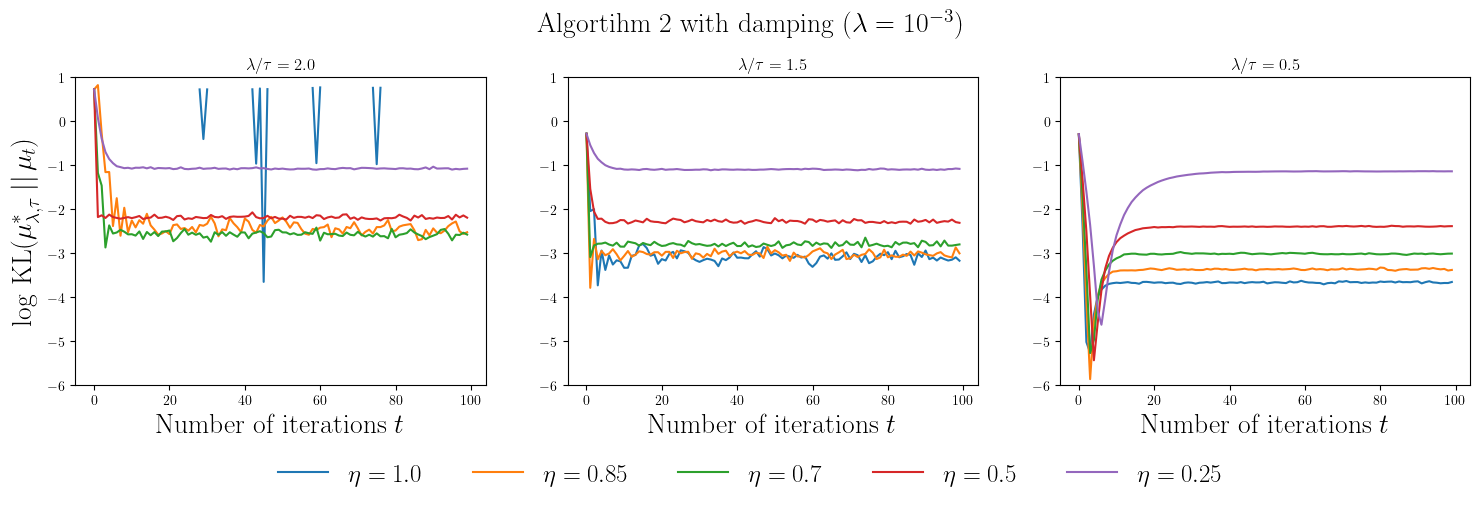

In [15]:
np.random.seed(0)

etas = [1.0, 0.85, 0.7, 0.5, 0.25]

ratios = [2.0, 1.5, 0.5]
fig, ax = plt.subplots(1, len(ratios), figsize=(6*len(ratios),4))

for idx, ratio in enumerate(ratios):
    tau = lamda / ratio
    for eta in etas:
        alg = InexactScheme(Sigmas, ms, ws, lamda, tau, noise=10**(-3))
        output = IsotropicGaussianSetup.run_simulation(algorithm=alg, n_iter=100, eta=eta)
        ax[idx].plot(np.log(output['KL']))
        legend.append(r'$\eta ='+str(eta)+'$')
    
    ax[idx].set_xlabel(r"Number of iterations $t$", fontsize=20)
    if idx == 0:
        ax[idx].set_ylabel(r"$\log\, \mathrm{KL}(\mu^{*}_{\lambda, \tau}\, ||\, \mu_{t})$", fontsize=20)
    ax[idx].set_title(r"$\lambda/\tau = "+str(ratio)+"$")
    ax[idx].set_ylim((-6,1))
    
    
labels = [r'$\eta ='+str(eta)+'$' for eta in etas]
fig.legend(ax[0].get_lines(), labels, loc='upper center', ncol=len(labels), fontsize=18, bbox_to_anchor=(0.5, -0.03))
    
fig.suptitle(r"\noindent Algortihm 2 with damping ($\lambda = 10^{-3}$)",
             fontsize=20, y=1.05)
save_fig(fig, "./figures/damping_with_noise.pdf")